# Machine Learning with ITK

## Overview

### Learning Objectives
* How to use ITK with machine learning libraries like PyTorch, scikit-learn.
* Understand how ITK can preprocess input images for effective model training and re-use.


### Content
1. Background
> * Basics of convolutional neural networks (CNNs) and U-Net
> * Convert ITK images to Numpy arrays and to Tensors
> * Preprocess data with ITK
2. nnU-Net
> * Install and pretrain a model
> * Predict with the pretrained model
> * Preprocess the data prior to the prediction
3. Summary

## Basics of convolutional neural networks (CNNs)
### Convolution
![Convolution operator](data/convolution.png)
Copy from [website](https://towardsdatascience.com/simple-introduction-to-convolutional-neural-networks-cdf8d3077bac).

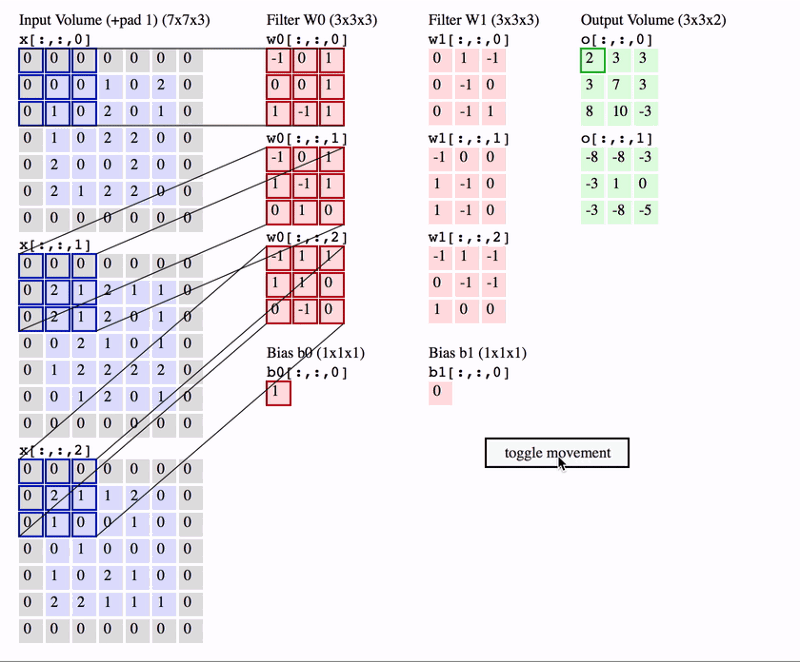
Source: http://cs231n.github.io/convolutional-networks/

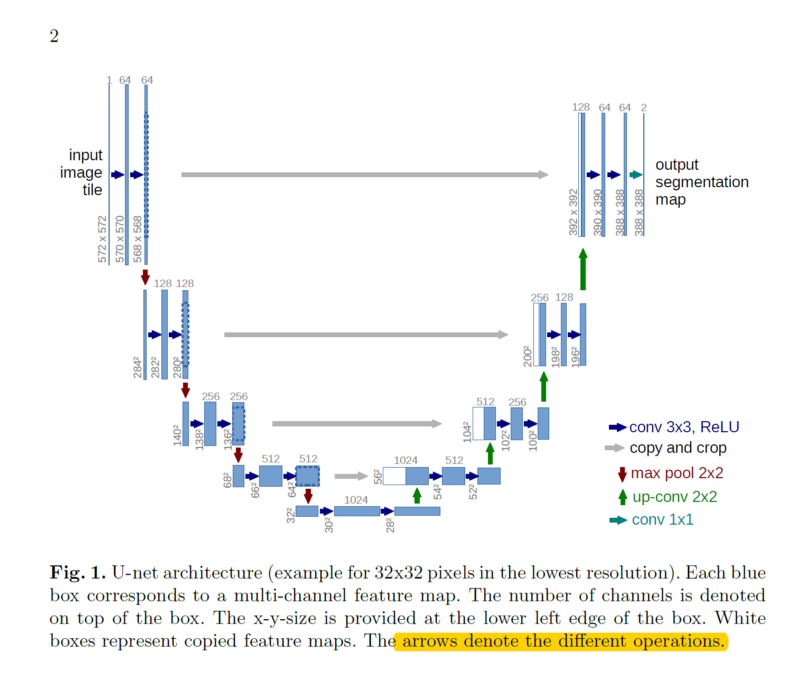
Source: Olaf Ronneberger et al., U-Net: Convolutional Networks for Biomedical Image Segmentation

## Use ITK with other machine learning libraries in Python
### Type names in C++, ITK Python and Numpy
| ITK Python   | Numpy        |
| :----------: | -----------: |
| itk.F        | numpy.float32|
| itk.D        | numpy.float64|
| itk.UC       | numpy.uint8  |
| itk.B        | bool         |

### Convert between an ITK image and a numpy array / xarray
* `itk.array_from_image(image)` and `itk.array_view_from_image(image)`
* `itk.image_from_array(arr)` and `itk.image_view_from_array(arr)`
* `itk.image_from_xarray(arr)` and `itk.xarray_from_image(image)`


## Preprocess data with ITK
* Understand your data
> [itk.StatisticsImageFilter](https://itk.org/Doxygen/html/classitk_1_1StatisticsImageFilter.html)
* Transform data with ITK filters
> * [itk.HistogramMatchingImageFilter](https://itk.org/Doxygen/html/classitk_1_1HistogramMatchingImageFilter.html)
> * [itk.NormalizeImageFilter](https://itk.org/Doxygen/html/classitk_1_1NormalizeImageFilter.html)
> * [itk.ResampleImageFilter](https://itk.org/Doxygen/html/classitk_1_1ResampleImageFilter.html)
> * ...
* Visualize data
> [itkwidegts](https://github.com/InsightSoftwareConsortium/itkwidgets)

## nnU-Net
* Proposed in the paper Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
* There are pretrained models with nnU-Net on datasets from Medical Segmentation Decathlon ([MSD](http://medicaldecathlon.com/)) 
* In this tutorial we preprocess test data as needed and predict with a pretrained model. Thus, it is needed to install a customized nnU-Net. Please check the versions of needed packages with check_env.ipynb before running the following experiment.

We have attached a pretrained model along with this tutorial. But before loading the model, let's prepare the test data.

In [2]:
from nnunet.inference import torch_predict
import torch
import itk
import numpy as np
from itkwidgets import view
from matplotlib import pyplot as plt
import sys


Please cite the following paper when using nnUNet:
Fabian Isensee, Paul F. Jäger, Simon A. A. Kohl, Jens Petersen, Klaus H. Maier-Hein "Automated Design of Deep Learning Methods for Biomedical Image Segmentation" arXiv preprint arXiv:1904.08128 (2020).
If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet




Bad key "text.kerning_factor" on line 4 in
/home/zhiyuan/anaconda3/envs/py3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Now, we read a brain MR image with ITK and visualize it with [itkwidgets](https://github.com/InsightSoftwareConsortium/itkwidgets). We refer to the paper Amber L. Simpson et al., A large annotated medical image dataset for the development and evaluation of segmentation algorithms, for more details about the data.


In [3]:
# read raw image and label image
file_name = 'data/hippocampus_001_0000.nii.gz'
label_file = 'data/label_hippocampus_001.nii.gz'

itk_img = itk.imread(file_name)
itk_lab = itk.imread(label_file)

names = [(0, 'Background'), (1, 'Head'), (2, 'Body')]
viewer = view(itk_img,
              label_map=itk_lab,
              label_map_names=names,
              label_map_blend=0.8,
              rotate=True,
              gradient_opacity=0.5,
              slicing_planes=True)
viewer
# convert label image to label map
# converter = itk.LabelImageToLabelMapFilter(Input=itk_lab)

# # overlay the label map with the raw image
# overlay_filter = itk.LabelMapOverlayImageFilter(Input=converter, FeatureImage=itk_img, Opacity=0.5)
# view(itk_img, ui_collapsed=True)
# RGBImageType = itk.Image[itk.RGBPixel[PixelType], 3]
# overlayFilter = itk.LabelMapOverlayImageFilter[type(itk_lab), type(itk_img), RGBImageType].New()
# overlayFilter.SetInput(converter.GetOutput())
# overlayFilter.SetFeatureImage(reader.GetOutput())
# overlayFilter.SetOpacity(0.5)
# view(itk_img, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.5, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pro…

### Exercise 1: Can you locate the region containing the left hippocampus given the label image?

- Read the label image with ITK. 
- View the image along different projections.
- Assign the results (start/end slice number) to the following variables.

In [5]:
# Assign the results here
x_start = None
y_start = None
z_start = None

x_end = None
y_end = None
z_end = None

In [6]:
# %load solutions/8_Machine_Learning_Exercise1.py

Next, we extract the region of interest with itk.ExtractImageFilter.

In [7]:
region_hipp = itk.ImageRegion[3]((x_start, 
                                  y_start, 
                                  z_start), 
                                 (x_end - x_start, 
                                  y_end - y_start, 
                                  z_end - z_start))
region_hipp = itk_img.GetLargestPossibleRegion()
hipp_slice = itk.extract_image_filter(itk_img, 
                                      extraction_region=region_hipp,
                                      ttype=(type(itk_img), type(itk_img)),
            direction_collapse_to_strategy=itk.ExtractImageFilterEnums.DirectionCollapseStrategy_DIRECTIONCOLLAPSETOIDENTITY)

### First try without any preprocessing

In [8]:
# load a pretrained model
pretrained_model_path = 'pretrained/'
predictor = torch_predict.TorchPredictor(pretrained_model_path)

# Segment the hippocampus
img_numpy = itk.array_from_image(hipp_slice)[np.newaxis, :]
output_softmax = predictor.predict(torch.from_numpy(img_numpy))
view(output_softmax[0], ui_collapsed=True)

loading parameters for folds, None
folds is None so we will automatically look for output folders (not using 'all'!)
found the following folds:  ['pretrained/fold_0', 'pretrained/fold_1', 'pretrained/fold_2', 'pretrained/fold_3', 'pretrained/fold_4']
using the following model files:  ['pretrained/fold_0/model_final_checkpoint.model', 'pretrained/fold_1/model_final_checkpoint.model', 'pretrained/fold_2/model_final_checkpoint.model', 'pretrained/fold_3/model_final_checkpoint.model', 'pretrained/fold_4/model_final_checkpoint.model']
debug: mirroring True mirror_axes (0, 1)
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction do

prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
predic

prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
prediction done
step_size: 0.5
do mirror: True
data shape: (1, 56, 40)
patch size: [56 40]
steps (x, y, and z): [[0], [0]]
number of tiles: 1
predic

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

### Compare statistics of the test data with a well calibrated data

We see the above segmentation result is blurry. Let's analyze the statistics of the test image and a well-calibrated training image. The well-calibrated training image is obtained according to the preprocessing discussed in the paper Isensee et al., 2020.

In [32]:
# read a well-calibrated image
train_file_name = 'data/hippocampus_002_0000.nii.gz'
trainImage = itk.imread(train_file_name)
well_callibrated_image = itk.normalize_image_filter(trainImage)
# template statistics
statistics_template = itk.StatisticsImageFilter[type(well_callibrated_image)].New()
statistics_template.SetInput(well_callibrated_image)
statistics_template.Update()
print('Statistics of a template image, mean: {}, sigma: {}, min: {}, max: {}'
      .format(statistics_template.GetMean(), 
      statistics_template.GetSigma(), 
      statistics_template.GetMinimum(), 
      statistics_template.GetMaximum())) 
print('==============')
# new data statistics
statistics_image = itk.StatisticsImageFilter[type(hipp_slice)].New()
statistics_image.SetInput(hipp_slice)
statistics_image.Update()
print('Statistics of a template image, mean: {}, sigma: {}, min: {}, max: {}'
.format(statistics_image.GetMean(), 
      statistics_image.GetSigma(), 
      statistics_image.GetMinimum(), 
      statistics_image.GetMaximum())) 

Statistics of a template image, mean: 0.21305388858580349, sigma: 0.4109093829386788, min: 0, max: 4
Statistics of a template image, mean: 63.52179271708683, sigma: 24.972681901659204, min: 2, max: 139


### Match statistics
1. Cast the test image to the same image type with the calibrated image.
2. Use [histogram_matching_image_filter](https://itk.org/Doxygen/html/classitk_1_1HistogramMatchingImageFilter.html) to transform the test image.
3. Use [normalize_image_filter](https://itk.org/Doxygen/html/classitk_1_1NormalizeImageFilter.html) to normalize the resulting image.
4. Review the statistics of transformed image.

In [47]:
## cast the image type
InputImageType = type(hipp_slice)
OutputImageType = ImageType = itk.Image[itk.F, 3]#type(well_callibrated_image)
cast_hipp_slice = itk.CastImageFilter[InputImageType, OutputImageType].New(hipp_slice)

## align the histogram to the training image
histo_match_filter = itk.histogram_matching_image_filter(input=cast_hipp_slice,
                                                      reference_image=well_callibrated_image)

## normalize the image
norm_cast_hipp_slice = itk.normalize_image_filter(histo_match_filter)

TypeError: Expecting argument of type itkImageF2 or itkImageSourceIF2.
Additional information:
Wrong number or type of arguments for overloaded function 'itkImageToImageFilterIF2IF2_SetInput'.
  Possible C/C++ prototypes are:
    itkImageToImageFilterIF2IF2::SetInput(itkImageF2 const *)
    itkImageToImageFilterIF2IF2::SetInput(unsigned int,itkImageF2 const *)


### Exercise 2: Please compare the statistics of the transformed test data and well_callibrated_image
* Show the mean, standard deviation, minimum and maximum of well_callibrated_image as before
* Use StatisticsImageFilter to investigate norm_cast_hipp_slice

In [ ]:
# %load solutions/8_Machine_Learning_Exercise2.py

### Predict the calibrated test data

In [ ]:
match_img_numpy = itk.array_from_image(norm_cast_hipp_slice)[np.newaxis, :]
match_output_softmax = predictor.predict(torch.from_numpy(match_img_numpy))
view(match_output_softmax[0], ui_collapsed=True)

Compared with the previous segmentation result (i.e., output_softmax), the calibration with ITK results in better segmentation.